In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

C:\Users\YanM1\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4971470970086186182
xla_global_id: -1
]


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [4]:
IMG_SIZE = 128

In [5]:
from PIL import Image
import os
import numpy as np
from tensorflow.keras.models import load_model


# Fonction pour charger les images avec PIL
def load_images(chemin_dossier):
    images = []
    max_images = 10000
    image = 1
    for filename in os.listdir(chemin_dossier):
        if image >= max_images:
            break
        chemin_image = os.path.join(chemin_dossier, filename)
        img = Image.open(chemin_image).convert('L')  # Convertit en niveaux de gris
        img = img.resize((IMG_SIZE, IMG_SIZE))  # Redimensionne l'image à la taille attendue
        img = np.array(img)  # Convertit l'image PIL en tableau NumPy
        img = img / 127.5 - 1.0  # Normalise dans la plage [-1, 1]
        if img is not None:
            images.append(img)
        image += 1
    return np.array(images)


In [6]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose
import os 

# Fonction pour créer le générateur
def build_generator(latent_dim):
    model = Sequential()
    model.add(layers.Dense(256 * (IMG_SIZE // 8) * (IMG_SIZE // 8), input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((IMG_SIZE // 8, IMG_SIZE // 8, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

# Fonction pour créer le discriminateur
def build_discriminator():
    img_shape = (IMG_SIZE, IMG_SIZE, 1)
    model = Sequential()
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Fonction pour compiler le modèle GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Fonction pour générer et afficher une image à partir du générateur dans le notebook
def generate_and_show_image(generator, gan_model, epochs, latent_dim):
    # Générer un vecteur de bruit aléatoire
    noise = np.random.randn(1, latent_dim)

    # Utiliser le générateur pour produire une image
    generated_img = generator.predict(noise)

    # Réajuster la normalisation [0, 1]
    generated_img = 0.5 * generated_img + 0.5  
    

    # Afficher l'image générée
    plt.imshow(generated_img[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title(f'Generated Image - Epoch {epochs}')
    plt.show()


# Fonction pour entraîner la GAN
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, images):
    print("Lancement de l'entraînement...")
    for epoch in range(epochs):
        # Entraînement du discriminateur
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]
        fake_imgs = generator.predict(np.random.randn(batch_size, latent_dim))
        labels_real = np.ones((batch_size, 1))
        labels_fake = np.zeros((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(real_imgs, labels_real)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, labels_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entraînement du générateur
        noise = np.random.randn(batch_size, latent_dim)
        labels_gan = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, labels_gan)

        # Affichage de la progression
        print(f"Epoch {epoch}/{epochs} [D loss: {d_loss} | G loss: {g_loss}]")
    print('Entraînement terminé !')

def train_or_load_model(latent_dim, epochs, batch_size):
    gan_name = "goblin.h5"
    # On vérifie que le modèle sauvegardé existe
    if os.path.exists('A:/python/'+gan_name):
        print("Chargement du modèle existant...")
        gan = tf.keras.models.load_model('A:/python/'+gan_name)
        print("Chargement du modèle terminé !")
    else:
        print("Entraînement d'un nouveau modèle...")
        # On crée et compile les modèles
        generator = build_generator(latent_dim)
        discriminator = build_discriminator()

        discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
        gan = build_gan(generator, discriminator)
        gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

        # On charge les images pour l'entraînement
        print('Chargement des images...')
        images = load_images("A:/python/training/images/images/")

        # On entraîne le modèle
        train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, images)

        # On sauvegarde le modèle après l'entraînement
        gan.save('A:/python/'+gan_name)

    # On récupère le générateur du modèle GAN
    generator = gan.layers[1]

    return gan, generator

In [7]:
# Paramètres
latent_dim = 100
img_shape = (IMG_SIZE, IMG_SIZE, 1)
batch_size = 32
epochs = 1000

# Charger ou entraîner le modèle
gan_model, generator_model = train_or_load_model(latent_dim, epochs, batch_size)

Entraînement d'un nouveau modèle...


Chargement des images...
Lancement de l'entraînement...
1/1 [==============================] - 0s 286ms/step

Epoch 0/1000 [D loss: 0.6998263001441956 | G loss: 0.5826815366744995]
1/1 [==============================] - 0s 117ms/step
Epoch 1/1000 [D loss: 0.5986039042472839 | G loss: 0.4337690472602844]
1/1 [==============================] - 0s 116ms/step
Epoch 2/1000 [D loss: 0.5174094438552856 | G loss: 0.2425556629896164]
1/1 [==============================] - 0s 110ms/step
Epoch 3/1000 [D loss: 0.43667097017169 | G loss: 0.11355232447385788]
1/1 [==============================] - 0s 117ms/step
Epoch 4/1000 [D loss: 0.418631624430418 | G loss: 0.05134982615709305]
1/1 [==============================] - 0s 111ms/step
Epoch 5/1000 [D loss: 0.3744906149804592 | G loss: 0.02882918156683445]
1/1 [==============================] - 0s 133ms/step
Epoch 6/1000 [D loss: 0.3295528758317232 | G loss: 0.009601306170225143]
1/1 [==============================

1/1 [==============================] - 0s 108ms/step
Epoch 59/1000 [D loss: 0.00022673144121654332 | G loss: 11.085456848144531]
1/1 [==============================] - 0s 118ms/step
Epoch 60/1000 [D loss: 0.0011643382313195616 | G loss: 10.37484359741211]
1/1 [==============================] - 0s 109ms/step
Epoch 61/1000 [D loss: 0.0009531217801850289 | G loss: 10.588065147399902]
1/1 [==============================] - 0s 116ms/step
Epoch 62/1000 [D loss: 0.0010450615372974426 | G loss: 9.384361267089844]
1/1 [==============================] - 0s 127ms/step
Epoch 63/1000 [D loss: 0.144796303473413 | G loss: 31.862035751342773]
1/1 [==============================] - 0s 122ms/step
Epoch 64/1000 [D loss: 1.3353915950283408 | G loss: 6.519560813903809]
1/1 [==============================] - 0s 113ms/step
Epoch 65/1000 [D loss: 1.6538445787670923 | G loss: 19.047225952148438]
1/1 [==============================] - 0s 109ms/step
Epoch 66/1000 [D loss: 0.00021180087151151383 | G loss: 29.8328

1/1 [==============================] - 0s 111ms/step
Epoch 124/1000 [D loss: 0.4856254756450653 | G loss: 2.4805586338043213]
1/1 [==============================] - 0s 110ms/step
Epoch 125/1000 [D loss: 0.5392409265041351 | G loss: 2.3234708309173584]
1/1 [==============================] - 0s 121ms/step
Epoch 126/1000 [D loss: 0.5170280337333679 | G loss: 2.328848361968994]
1/1 [==============================] - 0s 109ms/step
Epoch 127/1000 [D loss: 0.43832674622535706 | G loss: 2.1918697357177734]
1/1 [==============================] - 0s 116ms/step
Epoch 128/1000 [D loss: 0.4206709861755371 | G loss: 2.4060251712799072]
1/1 [==============================] - 0s 130ms/step
Epoch 129/1000 [D loss: 0.5784937739372253 | G loss: 2.1476430892944336]
1/1 [==============================] - 0s 131ms/step
Epoch 130/1000 [D loss: 0.49121081829071045 | G loss: 2.5795350074768066]
1/1 [==============================] - 0s 116ms/step
Epoch 131/1000 [D loss: 0.38262583315372467 | G loss: 2.85228395

1/1 [==============================] - 0s 128ms/step
Epoch 189/1000 [D loss: 0.48300449550151825 | G loss: 1.8778700828552246]
1/1 [==============================] - 0s 122ms/step
Epoch 190/1000 [D loss: 0.2538943290710449 | G loss: 2.2719533443450928]
1/1 [==============================] - 0s 131ms/step
Epoch 191/1000 [D loss: 0.4370834529399872 | G loss: 1.4953006505966187]
1/1 [==============================] - 0s 148ms/step
Epoch 192/1000 [D loss: 0.5946712493896484 | G loss: 1.6688215732574463]
1/1 [==============================] - 0s 109ms/step
Epoch 193/1000 [D loss: 0.39884041249752045 | G loss: 1.8344123363494873]
1/1 [==============================] - 0s 110ms/step
Epoch 194/1000 [D loss: 0.6093329787254333 | G loss: 1.4012608528137207]
1/1 [==============================] - 0s 110ms/step
Epoch 195/1000 [D loss: 0.4134427160024643 | G loss: 1.4273402690887451]
1/1 [==============================] - 0s 108ms/step
Epoch 196/1000 [D loss: 0.38410651683807373 | G loss: 1.6166348

1/1 [==============================] - 0s 108ms/step
Epoch 254/1000 [D loss: 0.8032222092151642 | G loss: 1.6635174751281738]
1/1 [==============================] - 0s 109ms/step
Epoch 255/1000 [D loss: 0.5594562292098999 | G loss: 1.7030301094055176]
1/1 [==============================] - 0s 109ms/step
Epoch 256/1000 [D loss: 0.704013466835022 | G loss: 1.5461755990982056]
1/1 [==============================] - 0s 121ms/step
Epoch 257/1000 [D loss: 0.7305536270141602 | G loss: 1.3520997762680054]
1/1 [==============================] - 0s 129ms/step
Epoch 258/1000 [D loss: 0.683455228805542 | G loss: 1.535787582397461]
1/1 [==============================] - 0s 111ms/step
Epoch 259/1000 [D loss: 0.5152269750833511 | G loss: 1.4788360595703125]
1/1 [==============================] - 0s 110ms/step
Epoch 260/1000 [D loss: 0.6123621463775635 | G loss: 1.4365770816802979]
1/1 [==============================] - 0s 111ms/step
Epoch 261/1000 [D loss: 0.706952303647995 | G loss: 1.44298112392425

1/1 [==============================] - 0s 111ms/step
Epoch 319/1000 [D loss: 0.5656580030918121 | G loss: 1.2168089151382446]
1/1 [==============================] - 0s 110ms/step
Epoch 320/1000 [D loss: 0.5389397144317627 | G loss: 1.2194139957427979]
1/1 [==============================] - 0s 115ms/step
Epoch 321/1000 [D loss: 0.5302691459655762 | G loss: 1.220369815826416]
1/1 [==============================] - 0s 127ms/step
Epoch 322/1000 [D loss: 0.5558502972126007 | G loss: 1.1742885112762451]
1/1 [==============================] - 0s 113ms/step
Epoch 323/1000 [D loss: 0.5389595031738281 | G loss: 1.3477919101715088]
1/1 [==============================] - 0s 116ms/step
Epoch 324/1000 [D loss: 0.4339004456996918 | G loss: 1.4105610847473145]
1/1 [==============================] - 0s 110ms/step
Epoch 325/1000 [D loss: 0.5408463180065155 | G loss: 1.4406235218048096]
1/1 [==============================] - 0s 108ms/step
Epoch 326/1000 [D loss: 0.5411392748355865 | G loss: 1.44298362731

1/1 [==============================] - 0s 125ms/step
Epoch 384/1000 [D loss: 0.447736456990242 | G loss: 1.3882489204406738]
1/1 [==============================] - 0s 114ms/step
Epoch 385/1000 [D loss: 0.5529198050498962 | G loss: 1.3159819841384888]
1/1 [==============================] - 0s 114ms/step
Epoch 386/1000 [D loss: 0.47894713282585144 | G loss: 1.5342559814453125]
1/1 [==============================] - 0s 124ms/step
Epoch 387/1000 [D loss: 0.48268936574459076 | G loss: 1.4848902225494385]
1/1 [==============================] - 0s 139ms/step
Epoch 388/1000 [D loss: 0.6282321214675903 | G loss: 1.58283269405365]
1/1 [==============================] - 0s 120ms/step
Epoch 389/1000 [D loss: 0.47022487223148346 | G loss: 1.6154760122299194]
1/1 [==============================] - 0s 115ms/step
Epoch 390/1000 [D loss: 0.59226194024086 | G loss: 1.3224382400512695]
1/1 [==============================] - 0s 146ms/step
Epoch 391/1000 [D loss: 0.6370960474014282 | G loss: 1.428328752517

1/1 [==============================] - 0s 140ms/step
Epoch 449/1000 [D loss: 0.45165690779685974 | G loss: 1.6509376764297485]
1/1 [==============================] - 0s 127ms/step
Epoch 450/1000 [D loss: 0.3646826148033142 | G loss: 1.9110300540924072]
1/1 [==============================] - 0s 134ms/step
Epoch 451/1000 [D loss: 0.420064315199852 | G loss: 1.682692527770996]
1/1 [==============================] - 0s 126ms/step
Epoch 452/1000 [D loss: 0.3251669555902481 | G loss: 1.8695096969604492]
1/1 [==============================] - 0s 151ms/step
Epoch 453/1000 [D loss: 0.7325315475463867 | G loss: 1.8361566066741943]
1/1 [==============================] - 0s 126ms/step
Epoch 454/1000 [D loss: 0.5188910216093063 | G loss: 2.135746955871582]
1/1 [==============================] - 0s 113ms/step
Epoch 455/1000 [D loss: 0.5148589313030243 | G loss: 1.8079588413238525]
1/1 [==============================] - 0s 129ms/step
Epoch 456/1000 [D loss: 0.680048257112503 | G loss: 1.7698541879653

1/1 [==============================] - 0s 114ms/step
Epoch 514/1000 [D loss: 2.138861060142517 | G loss: 4.155210494995117]
1/1 [==============================] - 0s 123ms/step
Epoch 515/1000 [D loss: 1.2467406019568443 | G loss: 3.338894844055176]
1/1 [==============================] - 0s 115ms/step
Epoch 516/1000 [D loss: 0.8455584421753883 | G loss: 2.103677988052368]
1/1 [==============================] - 0s 115ms/step
Epoch 517/1000 [D loss: 0.5268326699733734 | G loss: 1.6730811595916748]
1/1 [==============================] - 0s 136ms/step
Epoch 518/1000 [D loss: 0.551859125494957 | G loss: 1.5350520610809326]
1/1 [==============================] - 0s 114ms/step
Epoch 519/1000 [D loss: 0.5250004678964615 | G loss: 1.2052606344223022]
1/1 [==============================] - 0s 118ms/step
Epoch 520/1000 [D loss: 0.5656371414661407 | G loss: 1.4017196893692017]
1/1 [==============================] - 0s 120ms/step
Epoch 521/1000 [D loss: 0.48754145205020905 | G loss: 1.34203469753265

1/1 [==============================] - 0s 117ms/step
Epoch 579/1000 [D loss: 0.6390275061130524 | G loss: 1.32523775100708]
1/1 [==============================] - 0s 120ms/step
Epoch 580/1000 [D loss: 0.5859806835651398 | G loss: 1.2440714836120605]
1/1 [==============================] - 0s 111ms/step
Epoch 581/1000 [D loss: 0.4280252158641815 | G loss: 1.4689197540283203]
1/1 [==============================] - 0s 115ms/step
Epoch 582/1000 [D loss: 0.5378182232379913 | G loss: 1.3941574096679688]
1/1 [==============================] - 0s 120ms/step
Epoch 583/1000 [D loss: 0.5450462102890015 | G loss: 1.3088650703430176]
1/1 [==============================] - 0s 113ms/step
Epoch 584/1000 [D loss: 0.6034532189369202 | G loss: 1.1924399137496948]
1/1 [==============================] - 0s 112ms/step
Epoch 585/1000 [D loss: 0.5186832398176193 | G loss: 1.3244004249572754]
1/1 [==============================] - 0s 132ms/step
Epoch 586/1000 [D loss: 0.5615123808383942 | G loss: 1.240974903106

1/1 [==============================] - 0s 112ms/step
Epoch 644/1000 [D loss: 0.5365215837955475 | G loss: 1.091670274734497]
1/1 [==============================] - 0s 120ms/step
Epoch 645/1000 [D loss: 0.5399089157581329 | G loss: 1.2305461168289185]
1/1 [==============================] - 0s 151ms/step
Epoch 646/1000 [D loss: 0.5921460688114166 | G loss: 1.2150379419326782]
1/1 [==============================] - 0s 138ms/step
Epoch 647/1000 [D loss: 0.5120820105075836 | G loss: 1.2421406507492065]
1/1 [==============================] - 0s 116ms/step
Epoch 648/1000 [D loss: 0.6237593293190002 | G loss: 1.1817468404769897]
1/1 [==============================] - 0s 126ms/step
Epoch 649/1000 [D loss: 0.5081653892993927 | G loss: 1.2287101745605469]
1/1 [==============================] - 0s 112ms/step
Epoch 650/1000 [D loss: 0.5818578898906708 | G loss: 1.1005322933197021]
1/1 [==============================] - 0s 109ms/step
Epoch 651/1000 [D loss: 0.6078411936759949 | G loss: 1.23517489433

1/1 [==============================] - 0s 110ms/step
Epoch 709/1000 [D loss: 0.614889919757843 | G loss: 1.3541920185089111]
1/1 [==============================] - 0s 114ms/step
Epoch 710/1000 [D loss: 0.4387538880109787 | G loss: 1.4752535820007324]
1/1 [==============================] - 0s 111ms/step
Epoch 711/1000 [D loss: 0.5146844387054443 | G loss: 1.4054977893829346]
1/1 [==============================] - 0s 113ms/step
Epoch 712/1000 [D loss: 0.6631562113761902 | G loss: 1.2756340503692627]
1/1 [==============================] - 0s 114ms/step
Epoch 713/1000 [D loss: 0.4613800644874573 | G loss: 1.3848857879638672]
1/1 [==============================] - 0s 117ms/step
Epoch 714/1000 [D loss: 0.4436228722333908 | G loss: 1.443511962890625]
1/1 [==============================] - 0s 119ms/step
Epoch 715/1000 [D loss: 0.5040896534919739 | G loss: 1.497367262840271]
1/1 [==============================] - 0s 132ms/step
Epoch 716/1000 [D loss: 0.5485354661941528 | G loss: 1.3003427982330

1/1 [==============================] - 0s 117ms/step
Epoch 774/1000 [D loss: 0.4710574895143509 | G loss: 1.4138729572296143]
1/1 [==============================] - 0s 119ms/step
Epoch 775/1000 [D loss: 0.5381000936031342 | G loss: 1.384714126586914]
1/1 [==============================] - 0s 138ms/step
Epoch 776/1000 [D loss: 0.4805433750152588 | G loss: 1.4166797399520874]
1/1 [==============================] - 0s 112ms/step
Epoch 777/1000 [D loss: 0.5489322245121002 | G loss: 1.5493873357772827]
1/1 [==============================] - 0s 115ms/step
Epoch 778/1000 [D loss: 0.6315594911575317 | G loss: 1.2231415510177612]
1/1 [==============================] - 0s 120ms/step
Epoch 779/1000 [D loss: 0.5525239109992981 | G loss: 1.5667023658752441]
1/1 [==============================] - 0s 125ms/step
Epoch 780/1000 [D loss: 0.5231494605541229 | G loss: 1.4230852127075195]
1/1 [==============================] - 0s 141ms/step
Epoch 781/1000 [D loss: 0.5528570413589478 | G loss: 1.38679075241

1/1 [==============================] - 0s 119ms/step
Epoch 839/1000 [D loss: 0.5638027489185333 | G loss: 1.3082919120788574]
1/1 [==============================] - 0s 111ms/step
Epoch 840/1000 [D loss: 0.6329653859138489 | G loss: 1.4122283458709717]
1/1 [==============================] - 0s 114ms/step
Epoch 841/1000 [D loss: 0.691943883895874 | G loss: 1.4711627960205078]
1/1 [==============================] - 0s 119ms/step
Epoch 842/1000 [D loss: 0.5637348294258118 | G loss: 1.249427318572998]
1/1 [==============================] - 0s 114ms/step
Epoch 843/1000 [D loss: 0.4959457814693451 | G loss: 1.4073047637939453]
1/1 [==============================] - 0s 111ms/step
Epoch 844/1000 [D loss: 0.45278200507164 | G loss: 1.4567914009094238]
1/1 [==============================] - 0s 127ms/step
Epoch 845/1000 [D loss: 0.5098674148321152 | G loss: 1.3609447479248047]
1/1 [==============================] - 0s 118ms/step
Epoch 846/1000 [D loss: 0.39185671508312225 | G loss: 1.5492449998855

1/1 [==============================] - 0s 111ms/step
Epoch 904/1000 [D loss: 0.4719710052013397 | G loss: 1.3104699850082397]
1/1 [==============================] - 0s 114ms/step
Epoch 905/1000 [D loss: 0.4602448344230652 | G loss: 1.341766595840454]
1/1 [==============================] - 0s 113ms/step
Epoch 906/1000 [D loss: 0.47115258872509 | G loss: 1.4702322483062744]
1/1 [==============================] - 0s 135ms/step
Epoch 907/1000 [D loss: 0.4621078073978424 | G loss: 1.5750696659088135]
1/1 [==============================] - 0s 140ms/step
Epoch 908/1000 [D loss: 0.6412561535835266 | G loss: 1.4076932668685913]
1/1 [==============================] - 0s 120ms/step
Epoch 909/1000 [D loss: 0.6233106702566147 | G loss: 1.6447197198867798]
1/1 [==============================] - 0s 121ms/step
Epoch 910/1000 [D loss: 0.6277421116828918 | G loss: 1.3807244300842285]
1/1 [==============================] - 0s 112ms/step
Epoch 911/1000 [D loss: 0.5104845762252808 | G loss: 1.4796204566955

1/1 [==============================] - 0s 109ms/step
Epoch 969/1000 [D loss: 0.5008028149604797 | G loss: 1.3350576162338257]
1/1 [==============================] - 0s 124ms/step
Epoch 970/1000 [D loss: 0.5826786309480667 | G loss: 1.1172194480895996]
1/1 [==============================] - 0s 119ms/step
Epoch 971/1000 [D loss: 0.6311620771884918 | G loss: 1.1284170150756836]
1/1 [==============================] - 0s 115ms/step
Epoch 972/1000 [D loss: 0.6117294728755951 | G loss: 1.2508139610290527]
1/1 [==============================] - 0s 110ms/step
Epoch 973/1000 [D loss: 0.4514213055372238 | G loss: 1.2659589052200317]
1/1 [==============================] - 0s 112ms/step
Epoch 974/1000 [D loss: 0.4655410498380661 | G loss: 1.391510248184204]
1/1 [==============================] - 0s 111ms/step
Epoch 975/1000 [D loss: 0.536307618021965 | G loss: 1.2727301120758057]
1/1 [==============================] - 0s 112ms/step
Epoch 976/1000 [D loss: 0.4944923669099808 | G loss: 1.308949828147

C:\Users\YanM1\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 34ms/step


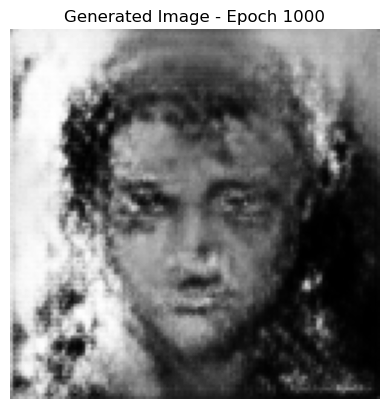

In [21]:
generate_and_show_image(gan_model.layers[0], gan_model, epochs, latent_dim)